In [39]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import statsmodels.formula.api as smf

# Resampling
* bootstrap
* permutation test

In [13]:
#  Practical Statistics for Data Scientists > 3. Statistical Experiments and Significance Testing
data = pd.read_csv('https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/refs/heads/master/data/web_page_data.csv')

data.Time = 100 * data.Time
data.head()

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


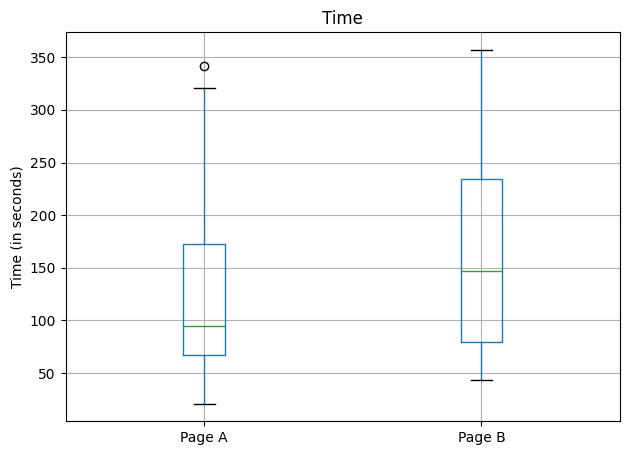

In [24]:
ax = data.boxplot(by='Page', column='Time')
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [25]:
# diff in mean
mean_a = data[data.Page == 'Page A'].Time.mean()
mean_b = data[data.Page == 'Page B'].Time.mean()
mean_b - mean_a

np.float64(35.66666666666667)

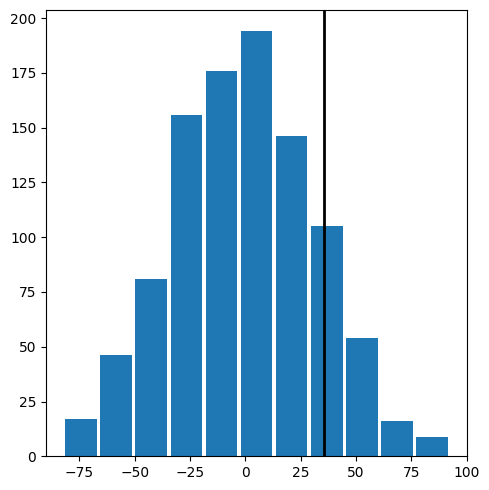

In [26]:
# permutation test

def perm_fun(x, nA, nB):
  import random
  n = nA + nB
  idx_B = set(random.sample(range(n), nB))
  idx_A = set(range(n)) - idx_B
  idx_A = list(idx_A)
  idx_B = list(idx_B)
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = data[data.Page == 'Page A'].shape[0]
nB = data[data.Page == 'Page B'].shape[0]

# perm_fun(data.Time, nA, nB)

perm_diffs = [perm_fun(data.Time, nA, nB) for _ in range(1000)]
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='black', lw=2)

plt.tight_layout()
plt.show()

In [27]:
np.mean(perm_diffs > mean_b - mean_a)

np.float64(0.128)

# Statistical Significance

Observed difference: 0.0368%


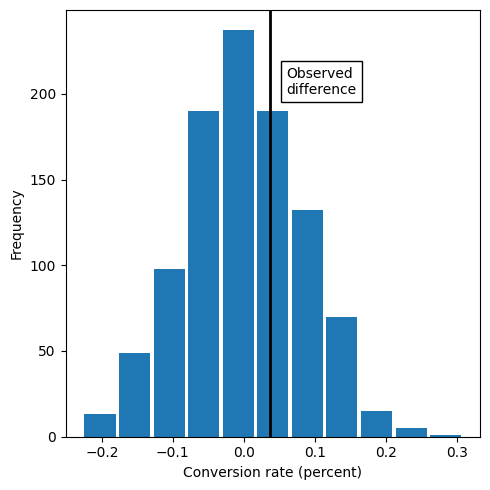

In [19]:
# Outcome         Price A   Price B
# Conversion      200       182
# No conversion   23,539    22,406

obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)
perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [20]:
# p-value
np.mean([diff > obs_pct_diff for diff in perm_diffs])

np.float64(0.325)

In [21]:
# p-value
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = scipy.stats.chi2_contingency(survivors)
print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


# t-Tests

In [22]:
res = scipy.stats.ttest_ind(data[data.Page == 'Page A'].Time,
                            data[data.Page == 'Page B'].Time,
                            equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


# ANOVA

In [30]:
data = pd.read_csv('https://raw.githubusercontent.com/gedeck/practical-statistics-for-data-scientists/refs/heads/master/data/four_sessions.csv')

data.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [38]:
# observed_variance = data.groupby('Page').mean().var()[0]
observed_variance = data.groupby('Page').mean().var().iloc[0]
print('Observed means:', data.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

def perm_test(df):
  df = df.copy()
  df['Time'] = np.random.permutation(df['Time'].values)
  # return df.groupby('Page').mean().var()[0]
  return df.groupby('Page').mean().var().iloc[0]

perm_variance = [perm_test(data) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
Pr(Prob) 0.08266666666666667


In [40]:
formula = 'Time ~ Page'
model = smf.ols(formula=formula, data=data).fit()

aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
Page,831.4,3.0,2.739825,0.077586
Residual,1618.4,16.0,NaN,NaN


# Chi-Square Test

# Multi-Arm Bandit Algorithm

# Power and Sample Size
* effect size
* power
* significance level

In [41]:
# current click through rate: 1.1%
# seek to 1.21%
effect_size = sm.stats.proportion_effectsize(0.0121, 0.011)
analysis = sm.stats.TTestIndPower()
result = analysis.solve_power(effect_size=effect_size,
                              alpha=0.05, power=0.8, alternative='larger')
print('Sample Size: %.3f' % result)

Sample Size: 116602.393
